In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Training

In [2]:
#Загрузка данных
df = pd.read_csv('LLCP2023_clean.csv', keep_default_na=False, dtype='category')

In [3]:
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [4]:
X = df.drop(columns=['_MENT14D'])  # Признаки
y = df['_MENT14D']  # Целевая переменная

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = XGBClassifier(
    n_estimators=100,          # количество деревьев
    learning_rate=0.1,         # скорость обучения
    max_depth=6,               # максимальная глубина деревьев
    min_child_weight=1,        # минимальный вес для дочернего узла
    gamma=0,                   # минимальное уменьшение потерь для создания нового разбиения
    subsample=0.8,             # доля выборки для построения каждого дерева
    colsample_bytree=0.8,      # доля признаков для построения каждого дерева
    objective='multi:softprob', # функция потерь для мультиклассовой классификации
    num_class=len(y.unique()), # количество классов
    random_state=42
)

In [8]:
# Функция обучения с выводом метрик
def train_model(model, X_train, X_test, y_train, y_test):
    print("Начало обучения модели...")

    # Обучение модели с отслеживанием прогресса
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #eval_metric=eval_metric,
        verbose=True
    )

    print("\nОбучение завершено!")
    return model

In [9]:
# Функция оценки модели
def evaluate_model(model, X_test, y_test):
    # Получение предсказаний
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    # Расчет метрик
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovo')

    print("\nРезультаты оценки модели:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Подробный отчет о классификации
    print("\nПодробный отчет о классификации:")
    print(classification_report(y_test, y_pred))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

In [10]:
# Обучение модели
trained_model = train_model(model, X_train, X_test, y_train, y_test)

Начало обучения модели...
[0]	validation_0-mlogloss:1.04456	validation_1-mlogloss:1.04456
[1]	validation_0-mlogloss:0.99989	validation_1-mlogloss:0.99994
[2]	validation_0-mlogloss:0.96032	validation_1-mlogloss:0.96040
[3]	validation_0-mlogloss:0.92627	validation_1-mlogloss:0.92637
[4]	validation_0-mlogloss:0.90261	validation_1-mlogloss:0.90275
[5]	validation_0-mlogloss:0.88296	validation_1-mlogloss:0.88302
[6]	validation_0-mlogloss:0.85953	validation_1-mlogloss:0.85957
[7]	validation_0-mlogloss:0.83894	validation_1-mlogloss:0.83909
[8]	validation_0-mlogloss:0.82027	validation_1-mlogloss:0.82049
[9]	validation_0-mlogloss:0.80487	validation_1-mlogloss:0.80520
[10]	validation_0-mlogloss:0.78967	validation_1-mlogloss:0.79014
[11]	validation_0-mlogloss:0.77628	validation_1-mlogloss:0.77701
[12]	validation_0-mlogloss:0.76451	validation_1-mlogloss:0.76543
[13]	validation_0-mlogloss:0.75448	validation_1-mlogloss:0.75556
[14]	validation_0-mlogloss:0.74520	validation_1-mlogloss:0.74645
[15]	vali

In [11]:
# Оценка модели
metrics = evaluate_model(trained_model, X_test, y_test)


Результаты оценки модели:
Accuracy: 0.7122
F1 Score (weighted): 0.7093
ROC AUC Score: 0.8710

Подробный отчет о классификации:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      7497
           1       0.69      0.55      0.61      3511
           2       0.71      0.79      0.75      5082

    accuracy                           0.71     16090
   macro avg       0.71      0.69      0.70     16090
weighted avg       0.71      0.71      0.71     16090



In [12]:
y_pred_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)
y_true = y_test

# Расчет accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Если нужны списки вместо numpy массивов:
y_pred_prob = y_pred_prob.tolist()
y_pred = y_pred.tolist()
y_true = y_true.tolist()

Accuracy: 0.7122436295835923


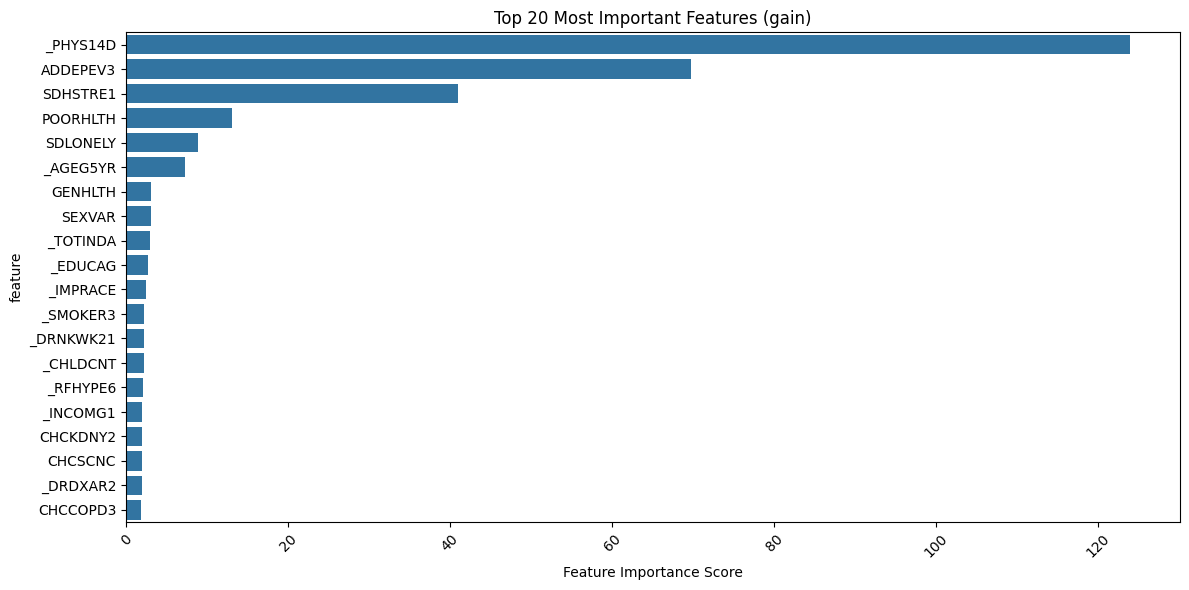

In [13]:
# 1. Feature importance на основе gain (наиболее популярный метод)
feature_importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})
importance_df = importance_df.sort_values('importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features (gain)')
plt.xlabel('Feature Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()